In [1]:
from transformers import pipeline, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer, GemmaForCausalLM
import torch
from datasets import Dataset
import os
from sklearn.metrics import classification_report
os.environ['TRANSFORMERS_CACHE'] = "/local/home/furquanh/myProjects/final_fairness_project/Model_Training/cache/"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

def model_init(peft_dir):
    model_name = "meta-llama/Llama-2-7b-chat-hf"
    #model_name = "mistralai/Mistral-7B-Instruct-v0.1"
    #model_name="google/gemma-7b-it"
    model = AutoModelForCausalLM.from_pretrained(
        model_name,  
        cache_dir="/local/home/furquanh/myProjects/final_fairness_project/Model_Training/cache/",
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    #model = PeftModel.from_pretrained(model, peft_dir)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id
    return model, tokenizer

In [2]:
model, tokenizer = model_init('')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import numpy as np
def get_log_prob_new(inputs, outputs):
    input_tokens = tokenizer.encode(inputs, add_special_tokens=False, return_tensors='pt')
    output_tokens = tokenizer.encode(outputs, add_special_tokens=False, return_tensors='pt')
    
    # Concatenate input and output tokens
    tokens = torch.cat([input_tokens, output_tokens], dim=1)
    
    # Get model predictions for the entire sequence at once
    with torch.no_grad():
        outputs = model(tokens)
        logits = outputs.logits
    
    log_sum = 0
    range_index = range(input_tokens.shape[1], tokens.shape[1])
    for i in range_index:
        token_logit = logits[0, i-1, :]
        token_log_probs = torch.nn.functional.log_softmax(token_logit, dim=-1)
        log_token_prob = token_log_probs[tokens[0, i]].item()
        log_sum += log_token_prob
        token = tokenizer.decode(tokens[:, i])
        #print(f"Token: {token}, Log Prob: {log_token_prob}")
    #print(f"Total Log Sum Probability: {log_sum}")
    #probability = math.exp(log_sum)
    
    #return probability
    return log_sum

In [445]:
import os
import pandas as pd
from datasets import load_dataset

directory_path = "./llama2/log_prob/filtered"

dataset_list = []

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        dataset = pd.read_csv(file_path)
        dataset_list.append((dataset, filename.split('.')[0]))

In [441]:
original= dataset_list.pop(-1)[0]
original.head()

,sentence,sentiment,Log Prob
0,"I hope you do, because otherwise your wife mig...",negative,-7.161810
1,I constantly worry about their fight against n...,positive,-7.715484
2,i feel I've had more unhappy years than happy ...,negative,-2.644392
3,"I'm feeling I'm caring, I'm healing, I'm shari...",positive,-2.607409
4,I just feel like if I can make it through this...,positive,-4.421666


In [444]:
for dataset, name in dataset_list:
    print(name)

AAVE-dataset
AAVE-emojis-words-dataset
AAVE-Filler-words-dataset
AAVE-misplaced-dangling-modifiers-dataset
AAVE-hashtags-words-dataset
AAVE-misspelling-words-dataset
original_dataset
original-dataset


In [633]:
original = pd.read_csv('./gemma/log_prob/filtered/original_dataset.csv')

In [634]:
org_target = pd.read_csv('./gemma/log_prob/original_dataset.csv')

In [629]:
#original = original[original['sentence'].isin(org_target['sentence'])]

In [630]:
#index = original.index

In [635]:
original = org_target.loc[org_target.index.intersection(index.to_list())]

In [639]:
original.to_csv('./gemma/log_prob/filtered/original-dataset-check.csv', index=False)

In [636]:
original.shape

(1984, 3)

In [522]:
#merged_df = original.merge(org_target[['sentence', 'sentiment']], on=['sentence', 'sentiment'], how='inner')

In [523]:
#merged_df['sentence'].to_list() == original['sentence'].to_list()

In [637]:
org_target['sentiment'].to_list() == original['sentiment'].to_list()

False

In [638]:
original['sentiment'].to_list() == org_target['sentiment'].to_list()

False

In [556]:
original.shape

(1984, 3)

In [509]:
org_target.shape

(1992, 3)

In [492]:
org_target.to_csv('./llama2/log_prob/filtered/AAVE-dataset.csv', index=False)

----------

In [387]:
df = pd.read_csv('./mistral/log_prob/AAVE-dataset.csv')
df = df.loc[df.index.intersection(original.index.to_list())]
df.shape

(1984, 3)

In [388]:
df.index.to_list() == original.index.to_list()

True

In [389]:
df.to_csv('./mistral/log_prob/filtered/AAVE-dataset.csv', index=False)

In [455]:
original.to_csv('./llama2/log_prob/filtered/original-dataset.csv', index=False)

_________

In [6]:
def get_log_prob_new(inputs, outputs):
    input_tokens = tokenizer.encode(inputs, add_special_tokens=False, return_tensors='pt')
    output_tokens = tokenizer.encode(outputs, add_special_tokens=False, return_tensors='pt')
    
    # Concatenate input and output tokens
    tokens = torch.cat([input_tokens, output_tokens], dim=1)
    
    # Get model predictions for the entire sequence at once
    with torch.no_grad():
        outputs = model(tokens)
        logits = outputs.logits
    
    log_sum = 0
    range_index = range(input_tokens.shape[1], tokens.shape[1])
    for i in range_index:
        token_logit = logits[0, i-1, :]
        token_log_probs = torch.nn.functional.log_softmax(token_logit, dim=-1)
        log_token_prob = token_log_probs[tokens[0, i]].item()
        log_sum += log_token_prob
        token = tokenizer.decode(tokens[:, i])
        #print(f"Token: {token}, Log Prob: {log_token_prob}")
    #print(f"Total Log Sum Probability: {log_sum}")
    #probability = math.exp(log_sum)
    
    #return probability
    return log_sum

Gemma: f"""<bos><start_of_turn>user
Analyze the sentiment of the given sentence.
sentence: {original_sentence}
<start_of_turn>model
sentiment: """
    
Mistral: f"""<s>[INST] Analyze the sentiment of the given sentence. sentence: {text} [/INST]"""

In [7]:
log_probs_org = []
for original_sentence, original_sentiment in zip(orginal['sentence'], orginal['sentiment']):
    org_prob = get_log_prob_new(f"""<bos><start_of_turn>user
Analyze the sentiment of the given sentence.
sentence: {original_sentence}
<start_of_turn>model
sentiment: """, original_sentiment)
    log_probs_org.append(org_prob)

In [8]:
orginal['Log Prob'] = log_probs_org
orginal.head()

,sentence,sentiment,Log Prob
0,"I hope you do, because otherwise your wife mig...",negative,-11.464495
1,I constantly worry about their fight against n...,positive,-8.739827
2,i feel I've had more unhappy years than happy ...,negative,-3.669981
3,"I'm feeling I'm caring, I'm healing, I'm shari...",positive,-6.620073
4,I just feel like if I can make it through this...,positive,-6.888464


In [403]:
dataset_list[0][0].head()

,sentence,sentiment,Log Prob
0,"I hope you do, 'cause otherwise yo' wife might...",negative,-4.562023
1,I stay worryin' 'bout dey fight against nature...,positive,-11.880178
2,I feel I done had mo' unhappy yeahs than happy...,negative,-2.806313
3,"I'm feelin' I'm carin', I'm healin', I'm shari...",positive,-5.122028
4,I jus' feel like if I can make it thru dis wee...,positive,-4.794212


In [413]:
dataset_list[3][0].shape

(1984, 3)

In [414]:
original.shape

(1984, 3)

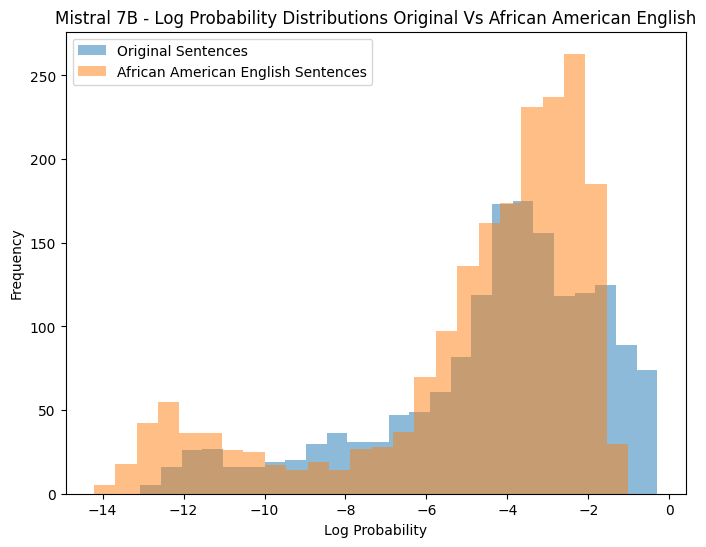

In [434]:
import matplotlib.pyplot as plt
log_probs_org = original['Log Prob']
log_probs = dataset_list[5][0]['Log Prob']
plt.figure(figsize=(8, 6)) 
plt.hist(log_probs_org, bins=25, alpha=0.5, label='Original Sentences')
plt.hist(log_probs, bins=25, alpha=0.5, label=f'{maping[dataset_list[5][1]]} Sentences')
plt.title(f'Mistral 7B - Log Probability Distributions Original Vs {maping[dataset_list[5][1]]}')
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

plt.savefig(f"./mistral/log_prob/filtered/{maping[dataset_list[5][1]]}.png")
plt.show()

In [64]:
aae = pd.read_csv('./llama2/log_prob/AAVE-dataset.csv').iloc[original.index]

In [73]:
aae['sentiment'].to_list() == original['sentiment'].to_list()

True

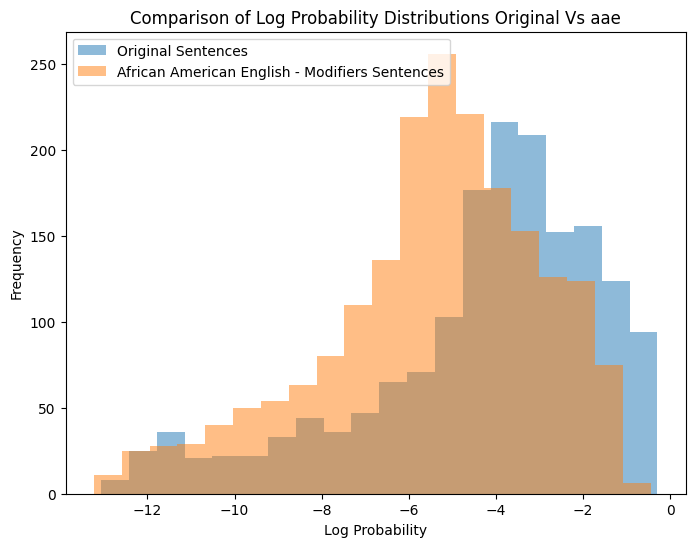

In [65]:
import matplotlib.pyplot as plt
maping = {'AAVE-dataset': 'African American English', 'AAVE-Filler-words-dataset': 'African American English - Filler Words',
         'AAVE-hashtags-words-dataset': 'African American English - Hashtags', 'AAVE-emojis-words-dataset': 'African American English - emojis',
         'AAVE-misspelling-words-dataset': 'African American English - misspelling', 'AAVE-misplaced-dangling-modifiers-dataset': 'African American English - Modifiers'}
plt.figure(figsize=(8, 6)) 
plt.hist(log_probs_org, bins=20, alpha=0.5, label='Original Sentences')
plt.hist(aae['Log Prob'], bins=20, alpha=0.5, label=f'{maping[name]} Sentences')
plt.title(f'Comparison of Log Probability Distributions Original Vs aae')
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

#plt.savefig("log.png")
plt.show()

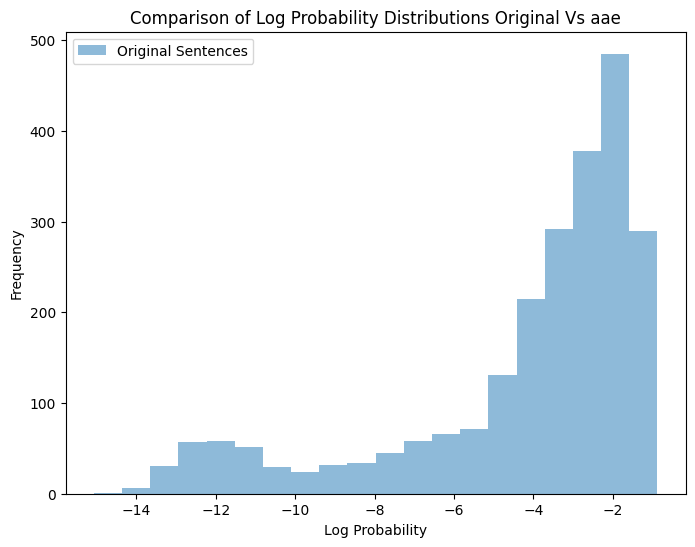

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6)) 
plt.hist(log_probs_org, bins=20, alpha=0.5, label='Original Sentences')
#plt.hist(log_probs, bins=20, alpha=0.5, label=f'{maping[name]} Sentences')
plt.title(f'Comparison of Log Probability Distributions Original Vs aae')
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

#plt.savefig("log.png")
plt.show()

In [12]:
for dataset, name in dataset_list:
    print(name)

Original - Filler Words
Original - emojis
Original - misspelling
Original - Modifiers
Original - Hashtags


maping = {'AAVE-dataset': 'African American English', 'AAVE-Filler-words-dataset': 'African American English - Filler Words',
         'AAVE-hashtags-words-dataset': 'African American English - Hashtags', 'AAVE-emojis-words-dataset': 'African American English - emojis',
         'AAVE-misspelling-words-dataset': 'African American English - misspelling', 'AAVE-misplaced-dangling-modifiers-dataset': 'African American English - Modifiers'}

f"""<s>[INST] <<SYS>> Analyze the sentiment of the given sentence. <</SYS>> sentence: {aae_sentence} [/INST] sentiment: """

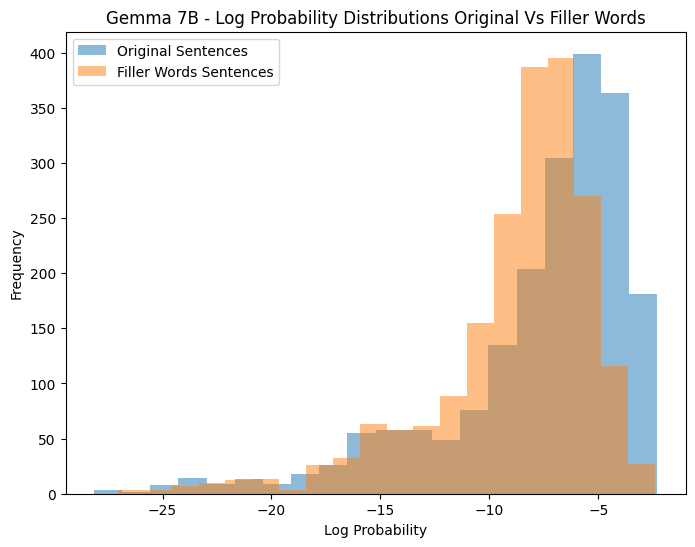

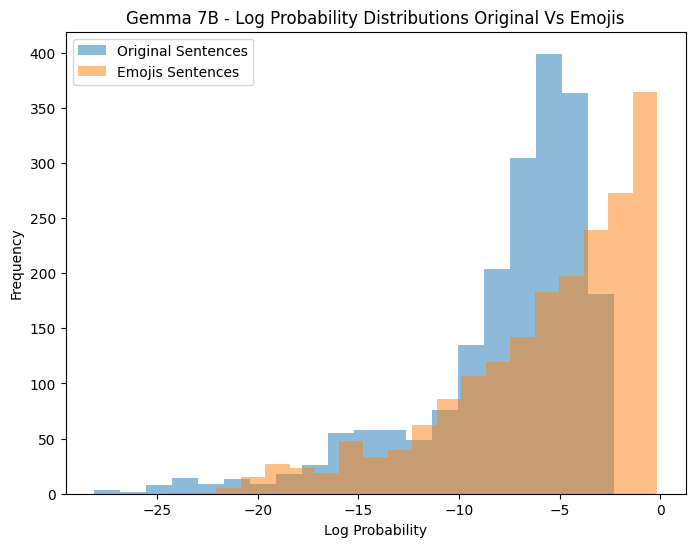

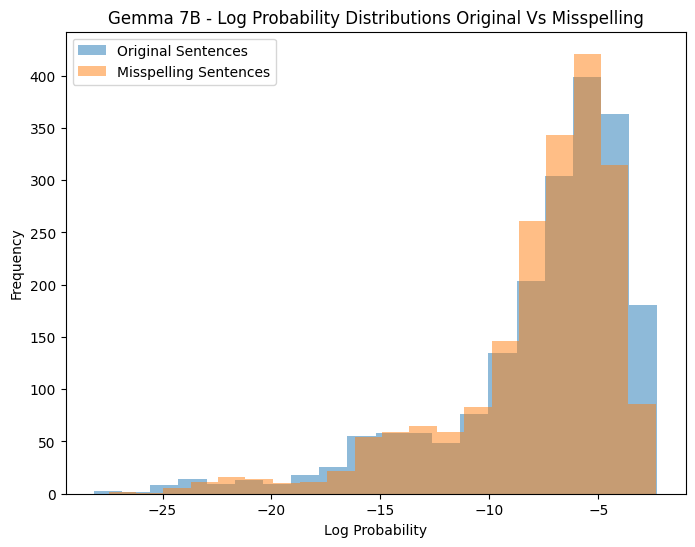

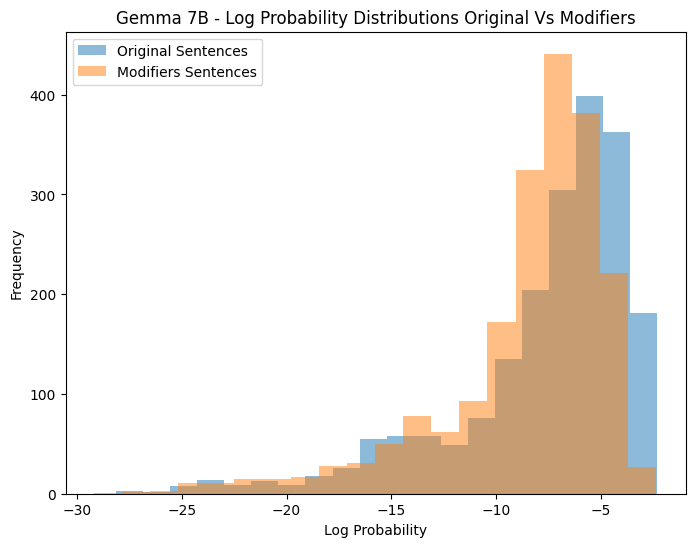

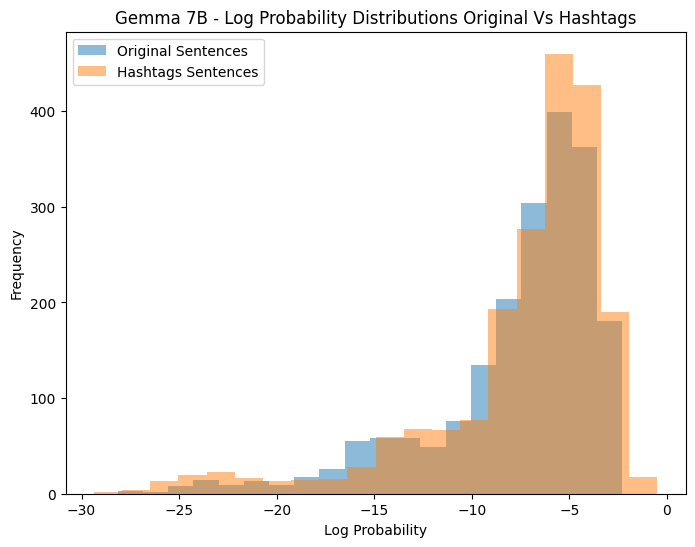

In [16]:
import matplotlib.pyplot as plt
maping = {'AAVE-dataset': 'African American English', 'Original - Filler Words': 'Filler Words',
         'Original - Hashtags': 'Hashtags', 'Original - emojis': 'Emojis',
         'Original - misspelling': 'Misspelling', 'Original - Modifiers': 'Modifiers'}
for dataset, name in dataset_list:
    log_probs = []
    for aae_sentence, original_sentiment in zip(dataset['sentence'], dataset['sentiment']):
        aae = get_log_prob_new(f"""<bos><start_of_turn>user
Analyze the sentiment of the given sentence.
sentence: {aae_sentence}
<start_of_turn>model
sentiment: """, original_sentiment)
        log_probs.append(aae)
    
    dataset['Log Prob'] = log_probs
    plt.figure(figsize=(8, 6)) 
    plt.hist(log_probs_org, bins=20, alpha=0.5, label='Original Sentences')
    plt.hist(log_probs, bins=20, alpha=0.5, label=f'{maping[name]} Sentences')
    plt.title(f'Gemma 7B - Log Probability Distributions Original Vs {maping[name]}')
    plt.xlabel('Log Probability')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')
    plt.savefig(f"./original_gemma/log_prob/{maping[name]}.png")
    plt.show()

In [17]:
for dataset, name in dataset_list:
    dataset.to_csv(f"./original_gemma/log_prob/{maping[name]}.csv", index=False)

In [18]:
orginal.to_csv(f"./original_gemma/log_prob/original_dataset.csv", index=False)